<a href="https://colab.research.google.com/github/danrleymontalvao/gemini_app_review/blob/main/app_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instalação e Importação dos Pacotes Utilizados

In [ ]:
!pip install -U -qq google-play-scraper

In [ ]:
!pip install -U -qq google-generativeai

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google_play_scraper import Sort, reviews_all, reviews
import google.generativeai as genai

### Extração e Tratamento dos Dados

In [ ]:
#Importando e apresentando os dados de reviews do app Meu SUS na Play Store

result = reviews_all(
'br.gov.datasus.cnsdigital', # id do app
sleep_milliseconds=0,
lang='pt-br', # língua das avaliações
country='br', # país das avaliações
sort=Sort.NEWEST, # ordenação dos dados
filter_score_with=None # filtrar por escore
)

In [ ]:
df= pd.DataFrame(result)
df.shape

(796, 11)

In [ ]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,e8112d55-2da5-42b4-9b32-a9d1536369ed,Badu Rodrigues,https://play-lh.googleusercontent.com/a-/ALV-U...,Vive dando erro quando queremos exportar algum...,3,0,73.13.01,2024-05-13 00:35:12,None,NaT,73.13.01
1,b944e35c-45fe-4d26-80c0-a5eb118f6b11,Manu Souza,https://play-lh.googleusercontent.com/a-/ALV-U...,"O aplicativo e bom,mas está dando erro pra bai...",2,0,73.13.01,2024-05-12 18:26:09,None,NaT,73.13.01
2,56898b9c-0479-42e9-a040-2de85e0a51db,Aline,https://play-lh.googleusercontent.com/a-/ALV-U...,Não está gerando o certificado de vacinação em...,3,0,73.13.01,2024-05-12 15:18:29,None,NaT,73.13.01
3,4a456568-0f41-48e1-8aae-f87c8d293179,Js Moniz,https://play-lh.googleusercontent.com/a/ACg8oc...,"✓ ""SRS INCOMPETENTES DEBOCHADOS !"" ✓""PARECE DE...",1,2,73.13.00,2024-05-12 14:58:02,Olá!\n\nAgradecemos a informação e lamentamos ...,2023-06-07 15:10:08,73.13.00
4,4755f943-afd5-4220-8184-5a1e2b9264c2,Isaias Antonio,https://play-lh.googleusercontent.com/a/ACg8oc...,"Muito bom, fácil de manusear!",5,0,73.13.01,2024-05-12 14:42:39,None,NaT,73.13.01


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              796 non-null    object        
 1   userName              796 non-null    object        
 2   userImage             796 non-null    object        
 3   content               796 non-null    object        
 4   score                 796 non-null    int64         
 5   thumbsUpCount         796 non-null    int64         
 6   reviewCreatedVersion  705 non-null    object        
 7   at                    796 non-null    datetime64[ns]
 8   replyContent          7 non-null      object        
 9   repliedAt             7 non-null      datetime64[ns]
 10  appVersion            705 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 68.5+ KB


In [ ]:
df = df[['reviewId', 'content', 'score', 'at', 'appVersion']]

In [ ]:
df['at'] = df['at'].dt.strftime('%m/%d/%Y')

In [ ]:
df.head()

,reviewId,content,score,at,appVersion
0,e8112d55-2da5-42b4-9b32-a9d1536369ed,Vive dando erro quando queremos exportar algum...,3,05/13/2024,73.13.01
1,b944e35c-45fe-4d26-80c0-a5eb118f6b11,"O aplicativo e bom,mas está dando erro pra bai...",2,05/12/2024,73.13.01
2,56898b9c-0479-42e9-a040-2de85e0a51db,Não está gerando o certificado de vacinação em...,3,05/12/2024,73.13.01
3,4a456568-0f41-48e1-8aae-f87c8d293179,"✓ ""SRS INCOMPETENTES DEBOCHADOS !"" ✓""PARECE DE...",1,05/12/2024,73.13.00
4,4755f943-afd5-4220-8184-5a1e2b9264c2,"Muito bom, fácil de manusear!",5,05/12/2024,73.13.01


### Importando o Gemini

In [ ]:
#Pegando a chave da API
with open("gemini_api.txt", "r") as f:
    acesso = f.read().strip()

chave, valor = acesso.split(":")

In [ ]:
#Listando os modelos disponíveis
for m in genai.list_models():
    if 'generateContent' in m.supported_generation_methods:
        print(m.name)

models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-1.5-pro-latest
models/gemini-pro
models/gemini-pro-vision


In [ ]:
genai.configure(api_key=valor)

# Configurando os parâmetros do modelo
generation_config = {
  "temperature": 0.5,
  "top_p": 0.95,
  "top_k": 0,
  "max_output_tokens": 8192,
}

#Configuraçóes de segurança
safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
]

#Inicializando o modelo.
model = genai.GenerativeModel(model_name="gemini-1.5-pro-latest",
                              generation_config=generation_config,
                              safety_settings=safety_settings)

## Análise dos Dados

In [ ]:
promotores = df[(df['score'] == 4) | (df['score'] == 5)]
promotores.shape[0]

481

In [ ]:
csat = np.round((promotores.shape[0]/df.shape[0])*100,2)
print('O valor do CSAT do app Meu SUS Digital é igual a {:.2f}%'.format(csat))

O valor do CSAT do app Meu SUS Digital é igual a 60.43%


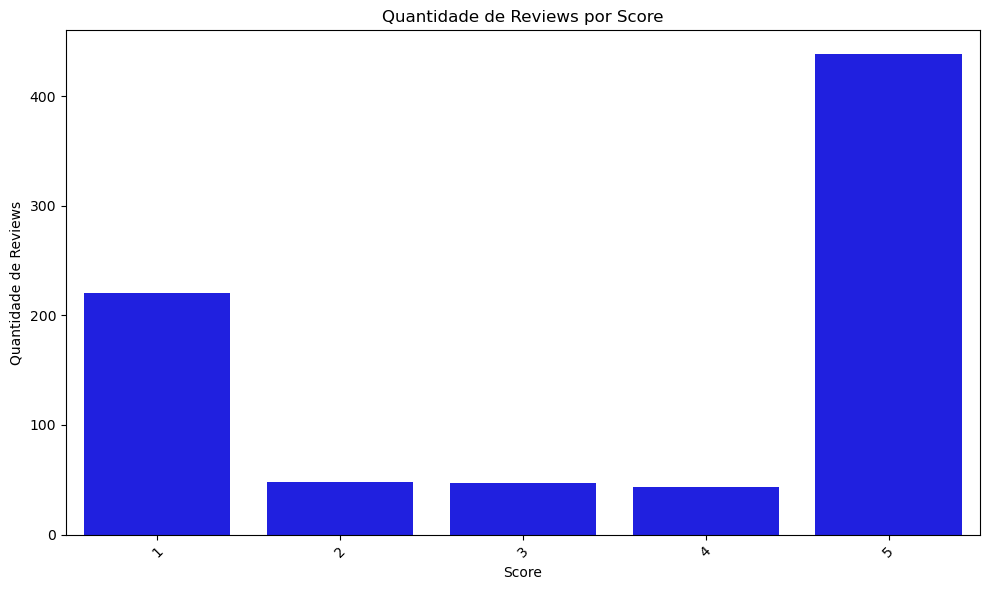

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df.score.value_counts().index, y=df.score.value_counts().values, data=df, color='blue')
plt.xticks(rotation=45)
plt.xlabel('Score')
plt.ylabel('Quantidade de Reviews')
plt.title('Quantidade de Reviews por Score')
plt.tight_layout()
plt.show()

In [ ]:
df['csat'] = df['score'].apply(lambda x: 1 if x >= 4 else 0)

# Crie a tabela dinâmica
tabela_dinamica = df.pivot_table(values='csat', index=['at', 'appVersion'], aggfunc='mean')

# Multiplique por 100 para obter a porcentagem
tabela_dinamica = tabela_dinamica * 100
tabela_dinamica = tabela_dinamica.reset_index()
tabela_dinamica

,at,appVersion,csat
0,04/08/2024,72.9.00,0.000000
1,04/08/2024,73.10.00,70.588235
2,04/09/2024,70.0.3,0.000000
3,04/09/2024,71.1.3,100.000000
4,04/09/2024,73.10.00,76.666667
...,...,...,...
67,05/11/2024,73.13.00,62.500000
68,05/11/2024,73.13.01,0.000000
69,05/12/2024,73.13.00,0.000000
70,05/12/2024,73.13.01,20.000000


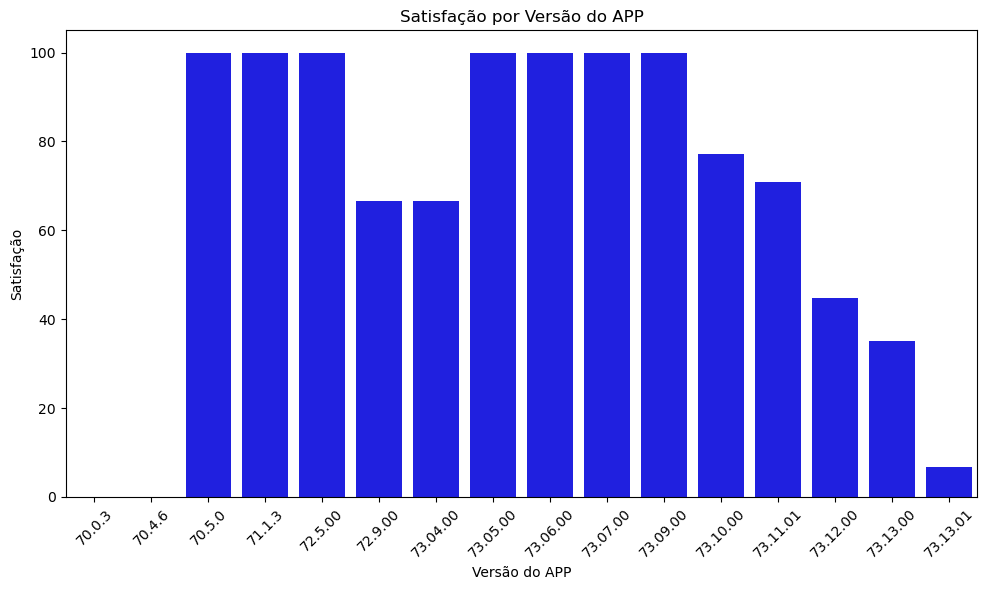

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=tabela_dinamica.groupby('appVersion').csat.mean().index,
            y=tabela_dinamica.groupby('appVersion').csat.mean().values, data=tabela_dinamica, color='blue')
plt.xticks(rotation=45)
plt.xlabel('Versão do APP')
plt.ylabel('Satisfação')
plt.title('Satisfação por Versão do APP')
plt.tight_layout()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


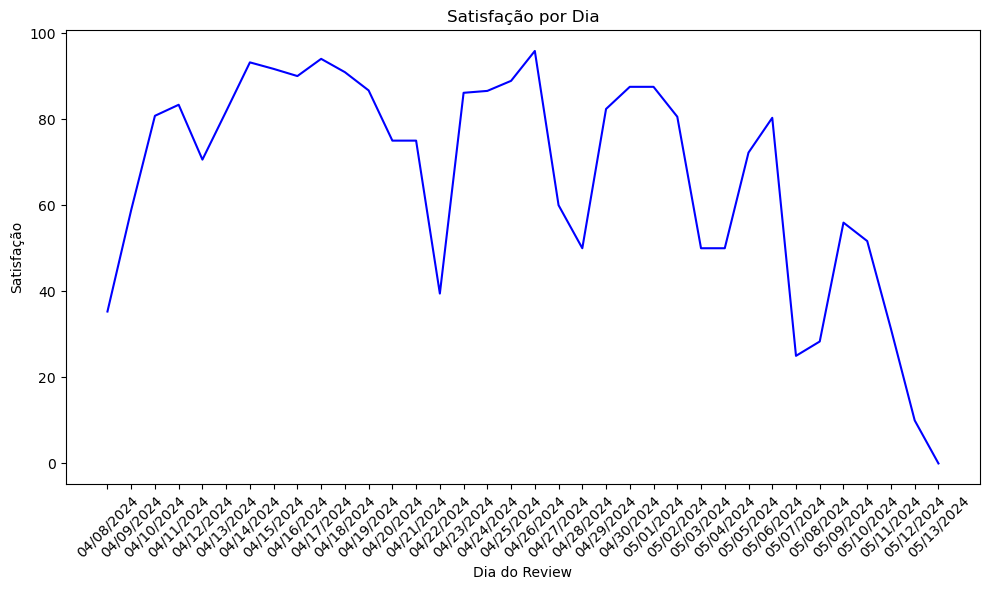

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=tabela_dinamica.groupby('at').csat.mean().index,
            y=tabela_dinamica.groupby('at').csat.mean().values, data=tabela_dinamica.groupby('at').csat.mean(), color='blue')
plt.xticks(rotation=45)
plt.xlabel('Dia do Review')
plt.ylabel('Satisfação')
plt.title('Satisfação por Dia')
plt.tight_layout()
plt.show()

In [ ]:
reviews = df['content'].to_list()

In [ ]:
# Incorpore os reviews no histórico do chat
initial_prompt = "O aplicativo Meu SUS Digital permite que o cidadão acompanhe, na palma da mão, o seu histórico clínico e acesse diversas soluções para que ele seja o protagonista da sua saúde. \n
                  É um compromisso contínuo do Governo Federal e do Ministério da Saúde em aprimorar a experiência do usuário e fortalecer o SUS. Aqui estão alguns reviews do aplicativo:\n\n" + "\n".join(reviews)

convo = model.start_chat(history=[
    {"role": "user", "parts": initial_prompt}
])

In [ ]:
convo.send_message("Como os usuarios se sentem com relação a funcionalidades do app?")
print(convo.last.text)

A análise dos reviews do aplicativo Meu SUS Digital revela uma forte dicotomia na opinião dos usuários em relação às suas funcionalidades. 

**Pontos Positivos:**

* **Funcionalidades básicas apreciadas:** Muitos usuários reconhecem e apreciam a funcionalidade principal do aplicativo, como o acesso rápido ao histórico de vacinação, especialmente para COVID-19, e ao número do cartão SUS. A praticidade de ter essa informação na palma da mão é frequentemente elogiada.
* **Programa Dignidade Menstrual:** Usuários mencionam o programa de absorventes gratuitos como um ponto positivo, reconhecendo o impacto social da iniciativa.

**Pontos Negativos:**

* **Funcionalidades frequentemente falham:** As maiores frustrações se concentram nas funcionalidades que frequentemente falham ou apresentam erros. A emissão de certificados de vacinação, especialmente em português, é alvo de diversas reclamações. A dificuldade em baixar o PDF da carteira de vacinação também é recorrente.
* **Informações desat

In [ ]:
convo.send_message("Dentro dessa amostragem, quantos usuarios reclamaram sobre a dificuldade em baixar o certificado de vacinação e quais as reclamações que precisam de mais atenção (me traga 5 exemplos)?")
print(convo.last.text)

Dentro da amostragem fornecida, pelo menos **7 usuários** mencionaram explicitamente a dificuldade em baixar o certificado de vacinação. As reclamações se concentram em erros no download,  emissão apenas em inglês ou espanhol, e a falta de funcionalidade para gerar o PDF.

Aqui estão 5 exemplos de reclamações que exigem atenção:

1. **"Não está gerando o certificado de vacinação em Português. Inglês e Espanhol está normal, mas quando selecionar a opção português, apresenta erro."** -  Este problema com a língua portuguesa precisa ser resolvido com urgência, pois impede o acesso à informação por grande parte dos usuários brasileiros.
2. **"Fica dando erro toda vez que vou baixar o certificado com às vacinas precisa melhorar muito."** -  A recorrência do erro no download indica um problema sistêmico que precisa ser investigado e corrigido.
3. **"Estou a uma semana tentando exportar para (.PDF) as minhas vacinas, porém não consigo e sempre da erro! Não está fazendo o básico esse app!"** -

In [ ]:
convo.send_message("Com relação a instabilidades e bugs, existe alguma funcionalidade em especifico que traz mais problemas ou os usuarios relatam de forma geral?")
print(convo.last.text)

Embora haja problemas relatados em diversas funcionalidades do Meu SUS Digital, a emissão e download do certificado de vacinação, especialmente a **carteira nacional de vacinação**, se destaca como a funcionalidade mais problemática e alvo de críticas recorrentes. 

Usuários relatam:

* **Erros frequentes no download:**  "Fica dando erro toda vez que vou baixar o certificado", "Não estou conseguindo baixar a carteira de vacinação digital. Erro."
* **Impossibilidade de gerar o PDF:** "O APP é bom, mas não estou conseguindo acessar minha carteira de vacina, só dar erro", "Não consigo baixar a carteira de vacinação digital. Aparecendo mensagem de que não foi possível baixar documento".
* **Certificado emitido apenas em inglês ou espanhol:** "Não está gerando o certificado de vacinação em Português. Inglês e Espanhol está normal, mas quando selecionar a opção português, apresenta erro."

Essa concentração de problemas em uma funcionalidade específica sugere que a falha pode estar relaciona

In [ ]:
convo.send_message("Existem comentarios de erros após atualização do app, se sim, me informe os mais frequentes e me traga 5 exemplos?")
print(convo.last.text)

Sim, diversos usuários relatam problemas após atualizações do aplicativo Meu SUS Digital. As reclamações mais frequentes são:

* **App não abre ou fica com a tela branca:** Usuários reportam que o aplicativo simplesmente não abre mais ou fica preso em uma tela branca após a atualização.
* **Login impossível:**  Problemas com o login, como a incapacidade de gerar o código de verificação em duas etapas, são mencionados após atualizações.
* **Funcionalidades que deixam de funcionar:**  Funcionalidades que antes funcionavam, como o acesso à carteira de vacinação, passam a apresentar erros após a atualização.
* **Lentidão e travamentos:**  O aplicativo se torna mais lento e sujeito a travamentos após atualizações.

**5 exemplos de comentários:**

1. **"Após o login só fica carregando mas não aparece nada :("** -  Este usuário relata o problema da tela de carregamento infinito após a atualização.
2. **"A atual versão: 73.13.01 não está rodando no Redmi Note 8 Pro. Testei umas versões anterio

In [ ]:
convo.send_message("Deixando de fora os problemas, quais os principais elogios que os usuarios fazem ao app?")
print(convo.last.text)

Apesar das críticas, muitos usuários reconhecem os benefícios do app Meu SUS Digital e tecem elogios importantes, principalmente em relação a:

**Praticidade e Facilidade de Acesso:**

* A praticidade de ter informações importantes como o número do cartão SUS e o histórico de vacinação na palma da mão é um dos elogios mais frequentes. Usuários destacam a facilidade de acesso e a conveniência de não precisar carregar documentos físicos.
* A interface do aplicativo, apesar de algumas críticas, é considerada intuitiva e fácil de usar por muitos usuários. 

**Cartão de Vacinação Digital:**

* A possibilidade de ter a carteira de vacinação digital é muito apreciada, especialmente para comprovar a vacinação contra COVID-19. 
* Usuários elogiam a organização e facilidade de visualizar as doses recebidas.

**Programa Dignidade Menstrual:**

* O programa de absorventes gratuitos é reconhecido como um ponto extremamente positivo, com usuários elogiando a iniciativa e o impacto social do programa

In [ ]:
convo.send_message("Preciso classificar o sentimento dos usuarios atraves dos comentarios em ruim, neutro ou bom. No qual ruim a pessoa não falou nada de bom; neutro ela tem reclamações, mas também acha que o app é funcional; bom quando só tem elogios (pode ser do tipo bom, top, show). Me traga quantos comentarios para cada categoria e 2 exemplos de cada comentario e categoria")
print(convo.last.text)

Analisando os comentários fornecidos, considerando a categorização proposta, temos a seguinte classificação:

**Ruim:** 43 comentários

* **Exemplos:**
    * "Lixo até não querer mais,ele trava e não gera os PDF corretamente"
    * "O aplicativo é muito ruim, trava muito não merece nem estrela."

**Neutro:** 24 comentários

* **Exemplos:**
    * "O aplicativo e bom,mas está dando erro pra baixar certificado na versão BRA podiam verificar pq ocorre"
    * "O APP é bom , mas não estou conseguindo acessar minha carteira de vacina , só dar erro , por favor criador desse app ,arruma isso , o APP tem tudo para ser eficaz e bom ,mais esses bugs é ruim"

**Bom:** 41 comentários

* **Exemplos:** 
    * "Muito bom, fácil de manusear!"
    * "Top"


Vale salientar que essa classificação é subjetiva e baseada em uma análise superficial dos comentários. Um sistema de análise de sentimentos mais preciso exigiria técnicas de Processamento de Linguagem Natural (PNL) para interpretar nuances e contexto